# Models

In [4]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import os
import ipaddress
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random

### Chargement des données

On charge les données et on encode les variable catégorielles, on modifie les labels de sortie pour avoir 'none' et 'malveillant'

In [5]:
df0=pd.read_csv("../data/final/Credential_Access.csv")
df1=pd.read_csv("../data/final/Defense_Evasion.csv")
df2=pd.read_csv("../data/final/Discovery.csv")
df3=pd.read_csv("../data/final/Exfiltration.csv")
df4=pd.read_csv("../data/final/Initial_Access.csv")
df5=pd.read_csv("../data/final/none.csv")
df6=pd.read_csv("../data/final/Persistence.csv")
df7=pd.read_csv("../data/final/Privilege_Escalation.csv")
df8=pd.read_csv("../data/final/Reconnaissance.csv")
listeDatasets=[df0,df1,df2,df3,df4,df5,df6,df7,df8]

categorical_columns = ['conn_state', 'protocol', 'service', 'history', 'label_tactic']
  
#Gestion des dates
for i in range(len(listeDatasets)):
    df=listeDatasets[i]

     # Modifier la colonne
    df['label_tactic'] = df['label_tactic'].apply(lambda x: "malveillant" if x != "none" else x)
    
    df['ts'] = pd.to_datetime(df['ts'], unit='s')
    
    df['year'] = df['ts'].dt.year
    df['month'] = df['ts'].dt.month
    df['day'] = df['ts'].dt.day
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['seconde'] = df['ts'].dt.second
    
    df['dayofweek'] = df['ts'].dt.dayofweek  # 0=lundi, 6=dimanche
    
    # Caractéristiques cycliques pour l'heure (pour préserver la nature cyclique)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Caractéristiques cycliques pour le jour de la semaine
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

    # Trier par timestamp pour calculer les différences temporelles
    df = df.sort_values('ts')
    df['time_since_last'] = df['ts'].diff().dt.total_seconds()

    # Remplacer la première valeur NaN par 0 ou une autre valeur appropriée
    df['time_since_last'] = df['time_since_last'].fillna(0)

    df=df.drop(['ts'], axis=1)
    df=df.drop(['year'], axis=1)
    df=df.drop(['month'], axis=1)
    df=df.drop(['day'], axis=1)
    df=df.drop(['hour'], axis=1)
    df=df.drop(['minute'], axis=1)
    df=df.drop(['seconde'], axis=1)

    #Gestion des adresses IP
    df['src_ip'] = df['src_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    df['dest_ip'] = df['dest_ip'].apply(lambda x: int(ipaddress.ip_address(x)))
    
    #Une IPV6 est un trop grand nombre, on ne peut pas le mettre en entier
    #On normalise donc les ip en divisant par la plus grande valeur possible (pour etre entre 0 et 1)
    df['src_ip'] = df['src_ip']/(2**128 - 1) # 2^128 est le max pour IPv6 car codée sur 128 bits
    df['dest_ip'] = df['dest_ip']/(2**128 - 1)

    df['src_ip']=df['src_ip'].astype(float)
    df['dest_ip']=df['dest_ip'].astype(float)

    listeDatasets[i]=df

#Diviser chaque dataset en train/test (85/15)
list_inconnu=['conn_state','protocol','history']
list_df_datasets=[]
compteur=0
for df in listeDatasets:
    train_df, test_inconnu_df = train_test_split(df, test_size=0.15, random_state=42)
    # Convertir en tableau NumPy pour accélérer les modifications
    data_array = test_inconnu_df[list_inconnu].values  # Extraire les colonnes à modifier
    num_rows, num_cols = data_array.shape

    # Générer un masque pour sélectionner aléatoirement 1, 2 ou 3 colonnes par ligne
    for i in range(num_rows):
        compteur += 1
        if compteur % 10000 == 0:  # Affiche seulement toutes les 10 000 lignes pour ne pas ralentir
            print(f"Lignes traitées : {compteur}")

        # Sélectionner aléatoirement des colonnes à modifier
        num_cols_to_modify = random.choice([1, 2, 3])
        cols_to_change = random.sample(range(num_cols), num_cols_to_modify)

        # Modifier directement les valeurs
        for col in cols_to_change:
            data_array[i, col] = 'unknown'

    # Remettre les données modifiées dans le DataFrame
    test_inconnu_df[list_inconnu] = data_array

    # Ajouter à la liste sans refaire de concaténation inutile
    list_df_datasets.append(pd.concat([train_df, test_inconnu_df], ignore_index=True))

# Remplacer listeDatasets en une seule opération
listeDatasets = list_df_datasets

# Créer et stocker les encodeurs
encoders = {}
for col in categorical_columns:
    # Collecter toutes les valeurs uniques de TOUS les datasets
    all_values = pd.concat([df[col] for df in listeDatasets]).unique()
    
    # Créer et ajuster l'encodeur sur toutes les valeurs possibles
    encoders[col] = LabelEncoder().fit(all_values)
    
    # Appliquer l'encodeur à chaque dataset
    for df in listeDatasets:
        df[col] = encoders[col].transform(df[col])


Lignes traitées : 10000
Lignes traitées : 20000
Lignes traitées : 30000
Lignes traitées : 40000
Lignes traitées : 50000
Lignes traitées : 60000
Lignes traitées : 70000
Lignes traitées : 80000
Lignes traitées : 90000
Lignes traitées : 100000
Lignes traitées : 110000
Lignes traitées : 120000
Lignes traitées : 130000
Lignes traitées : 140000
Lignes traitées : 150000
Lignes traitées : 160000
Lignes traitées : 170000
Lignes traitées : 180000
Lignes traitées : 190000
Lignes traitées : 200000
Lignes traitées : 210000
Lignes traitées : 220000
Lignes traitées : 230000
Lignes traitées : 240000
Lignes traitées : 250000
Lignes traitées : 260000
Lignes traitées : 270000
Lignes traitées : 280000
Lignes traitées : 290000
Lignes traitées : 300000
Lignes traitées : 310000
Lignes traitées : 320000


Affichage de la structure d'un dataset encodé

In [6]:
print(listeDatasets[1].columns)
print(listeDatasets[7]["dest_ip"].head())

Index(['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history', 'src_ip', 'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_ip', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'label_tactic', 'dayofweek',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'time_since_last'],
      dtype='object')
0    7.067402e-30
1    7.067396e-30
2    7.067404e-30
3    7.067396e-30
4    7.067402e-30
Name: dest_ip, dtype: float64


### Separation des données

In [7]:
#Diviser chaque dataset en train/test (80/20)
train_dfs = []
test_dfs = []

for df in listeDatasets:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

#Concaténer les ensembles
combined_train = pd.concat(train_dfs)
combined_test = pd.concat(test_dfs)

print(combined_test.head())
print(combined_test.shape)
print(combined_train.columns)

       conn_state  duration  local_orig  local_resp  protocol  service  \
6735            6  0.022819           0           0         1       18   
15280           6  0.733703           0           0         1       18   
28665           6  0.838346           0           0         1       18   
38545           6  0.036003           0           0         3       18   
6434            6  1.442142           0           0         1       18   

       history        src_ip  src_port  orig_bytes  ...  resp_pkts  \
6735        30  7.067404e-30     44147       686.0  ...         48   
15280       30  7.067395e-30     37217      1046.0  ...         68   
28665       30  7.067399e-30     39683      1005.0  ...         68   
38545       61  7.067395e-30     42281       686.0  ...         48   
6434        30  7.067396e-30     36289      1047.0  ...         68   

       resp_ip_bytes  missed_bytes  label_tactic  dayofweek  hour_sin  \
6735           47844             0             0          5 -

### Entrainement du modèle

In [8]:
features = ['conn_state', 'duration', 'local_orig', 'local_resp', 'protocol',
       'service', 'history',  'src_port', 'orig_bytes', 'orig_pkts',
       'orig_ip_bytes', 'dest_port', 'resp_bytes', 'resp_pkts',
       'resp_ip_bytes', 'missed_bytes', 'time_since_last']

#On retire les features temporelles, et les IP

label='label_tactic'



# Préparer X et y
X_train = combined_train[features]
y_train = combined_train[label]
X_test = combined_test[features]
y_test = combined_test[label]

# Créer les datasets LightGBM
categorical_indices = [features.index(col) for col in categorical_columns[:-1] ]#On recupere l'index de chaque colonne catégorielle (sauf le label)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_indices)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)



# 9. Paramètres LightGBM
num_classes = len(encoders['label_tactic'].classes_)
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': 1
}

# 10. Entraîner le modèle
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 1712479, number of used features: 17
[LightGBM] [Info] Start training from score -1.350555
[LightGBM] [Info] Start training from score -0.299885


### Affichage d'un arbre

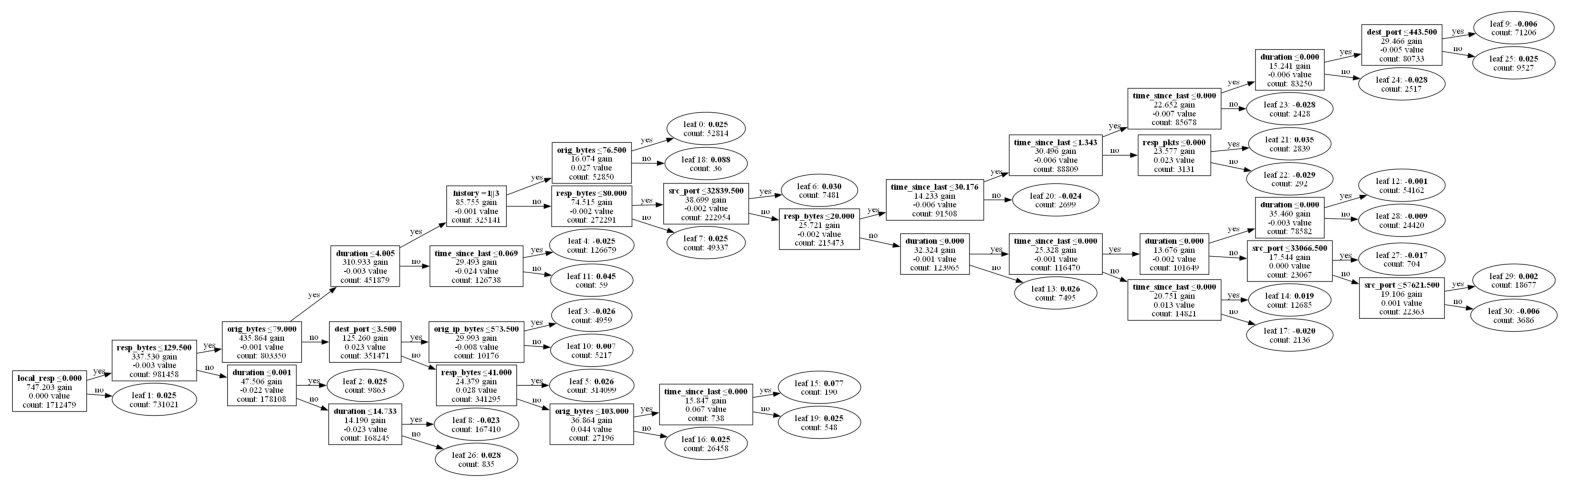

In [9]:
# Afficher l'arbre (exemple pour le premier arbre)
ax = lgb.plot_tree(gbm, tree_index=-1, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])

plt.show()

### Evaluation du modèle

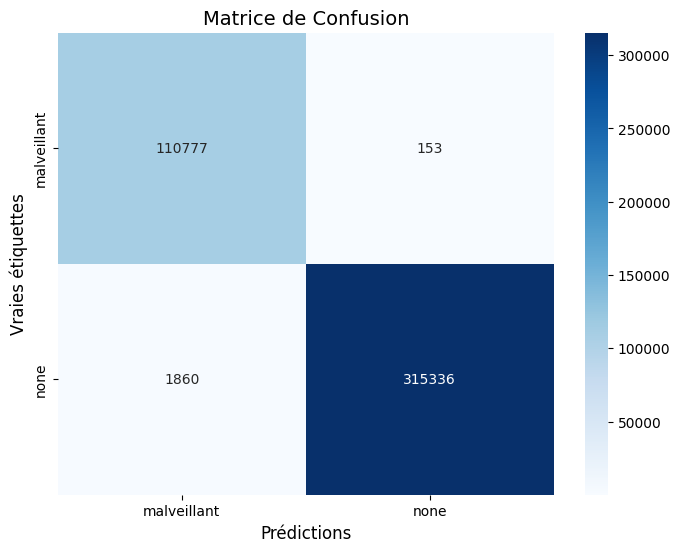


Rapport de classification:
              precision    recall  f1-score   support

 malveillant       0.98      1.00      0.99    110930
        none       1.00      0.99      1.00    317196

    accuracy                           1.00    428126
   macro avg       0.99      1.00      0.99    428126
weighted avg       1.00      1.00      1.00    428126



In [10]:
# 11. Évaluer le modèle
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_class = np.argmax(y_pred, axis=1)

# Reconvertir en labels textuels pour l'évaluation
y_pred_labels = encoders['label_tactic'].inverse_transform(y_pred_class)
y_test_labels = encoders['label_tactic'].inverse_transform(y_test)

# Afficher les résultatsx   
from sklearn.metrics import classification_report, confusion_matrix
cm=confusion_matrix(y_test, y_pred_class)

labels = np.unique(y_test_labels)

# Afficher sous forme de heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels , yticklabels=labels)
#annot= affichage des valeurs dans les carrés  fmt = formatage des valeurs, d = entier (par exemple si c'est 0.87, il sera affiché 1).

# Ajouter les labels APRÈS avoir tracé la heatmap
ax.set_xlabel('Prédictions', fontsize=12)
ax.set_ylabel('Vraies étiquettes', fontsize=12)
ax.set_title('Matrice de Confusion', fontsize=14)
plt.show()



print("\nRapport de classification:")
print(classification_report(y_test_labels, y_pred_labels))

# Sauvegarder le modèle et les encodeurs

model_package = {
    'model': gbm,
    'encoders': encoders,
    'features': features
}

with open('lightgbm_model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

In [11]:
y_pred_prob = y_pred[:,:1] 

liste_probas = []  # Stocker les probabilités des erreurs
for i in range(len(y_pred_prob)):
    if (y_test_labels[i]=='malveillant') and (y_pred_labels[i]!='malveillant'):  # Si erreur
        liste_probas.append(y_pred_prob[i])

print("***Moyenne de probabilité de malveillance des erreurs : ")
print("**des malveillants non reconnus : ", np.mean(liste_probas))  # Afficher la probabilité moyenne des erreurs
print(pd.DataFrame(liste_probas).describe())

liste_probas = []  # Stocker les probabilités des erreurs
for i in range(len(y_pred_prob)):
    if (y_test_labels[i]!='malveillant') and (y_pred_labels[i]=='malveillant'):  # Si erreur
        liste_probas.append(y_pred_prob[i])

print("\n**des non-malveillabts reconnus malveillants : ", np.mean(liste_probas))  # Afficher la probabilité moyenne des erreurs
print(pd.DataFrame(liste_probas).describe())

***Moyenne de probabilité de malveillance des erreurs : 
**des malveillants non reconnus :  0.09647040525950795
                0
count  153.000000
mean     0.096470
std      0.078107
min      0.010385
25%      0.041351
50%      0.051854
75%      0.173398
max      0.459706

**des non-malveillabts reconnus malveillants :  0.8602993297917467
                 0
count  1860.000000
mean      0.860299
std       0.125300
min       0.500953
25%       0.789679
50%       0.922946
75%       0.934325
max       0.994505


Target vs Feature (Boxplot, Violin Plot, ou Histogramme)
- Permet d'observer la distribution des features en fonction de la classe cible.
- Boxplot pour voir la médiane et les quartiles des features par classe.
- Violin plot pour voir la densité des données.
- Histogrammes empilés pour observer la répartition

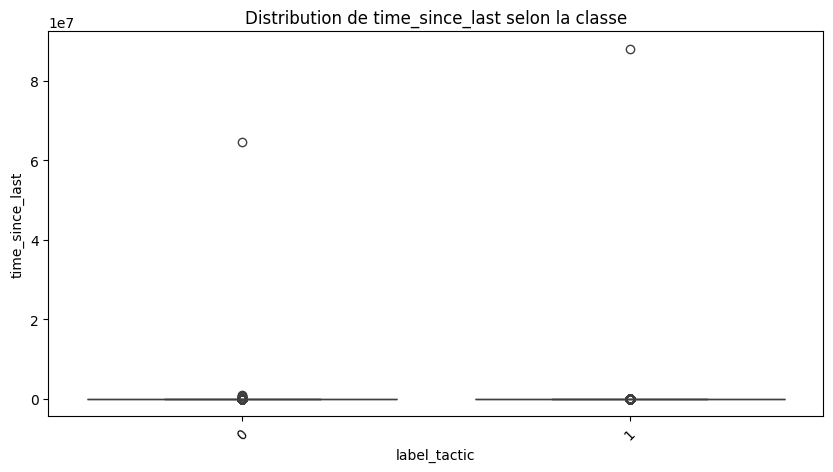

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_to_plot = 'time_since_last'  # Choisir une feature continue

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_train, y=X_train[feature_to_plot])
plt.title(f"Distribution de {feature_to_plot} selon la classe")
plt.xticks(rotation=45)
plt.show()


Courbe de Calibration
- Permet de vérifier si les probabilités prédites sont bien calibrées.
- Idéale pour comprendre si ton modèle est trop confiant ou sous-estime certaines classes.

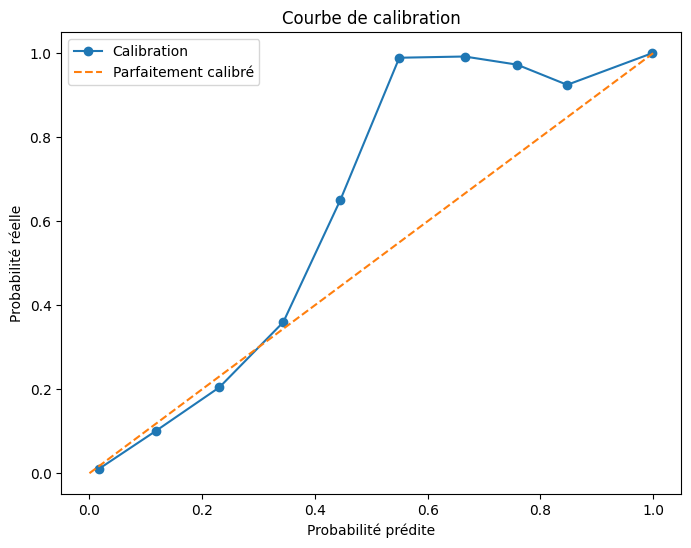

In [13]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test == 1, y_pred[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration")
plt.plot([0, 1], [0, 1], linestyle="--", label="Parfaitement calibré")
plt.xlabel("Probabilité prédite")
plt.ylabel("Probabilité réelle")
plt.legend()
plt.title("Courbe de calibration")
plt.show()


Feature Importance (LightGBM)
- Montre quelles features influencent le plus les prédictions.

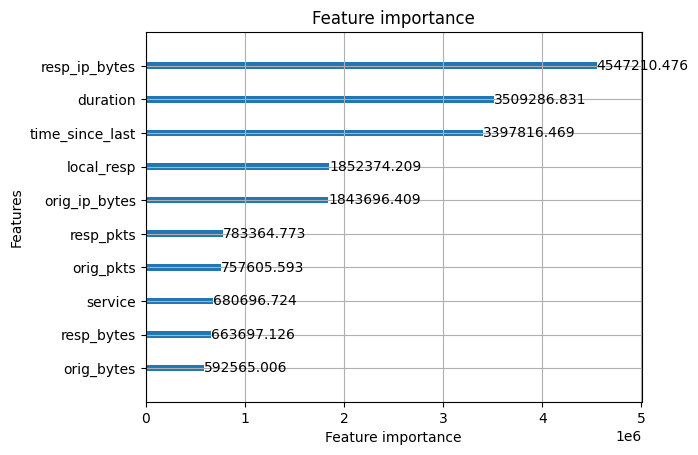

In [14]:
lgb.plot_importance(gbm, max_num_features=10, importance_type="gain")
plt.show()


SHAP (SHapley Additive Explanations)
- Explique l’impact de chaque feature sur une prédiction donnée

In [ ]:
import shap

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


Courbes de Décision
- Pour visualiser les frontières de décision (possible si tu réduis ton modèle à 2D).

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.7)
plt.colorbar()
plt.title("Projection PCA des données d'entraînement")
plt.show()


KeyboardInterrupt: 

Matrice de Corrélation
- Permet de voir les relations entre les variables (certaines peuvent être redondantes).
- Utile pour identifier les features qui influencent fortement le modèle.

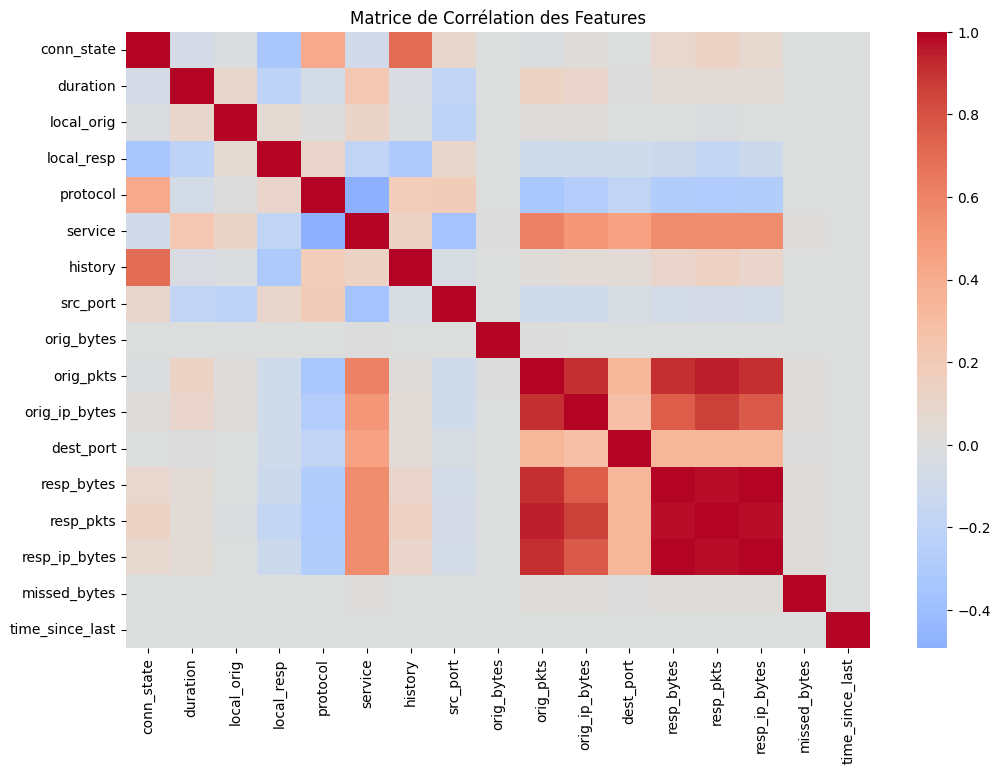

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Matrice de Corrélation des Features")
plt.show()

Courbes ROC et AUC par classe
- Mesure la capacité du modèle à distinguer les classes.
- Plus l’aire sous la courbe (AUC) est proche de 1, mieux c’est.

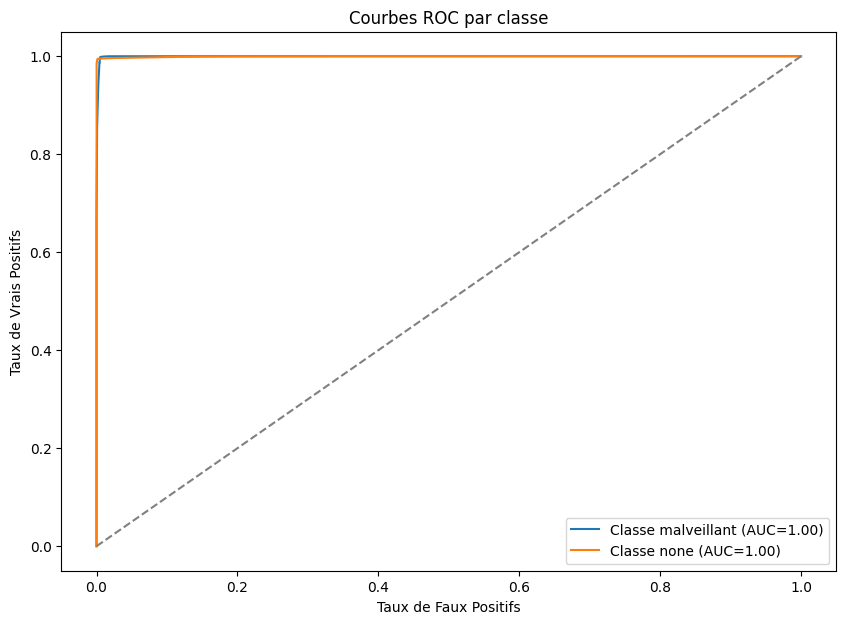

In [18]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
    plt.plot(fpr, tpr, label=f'Classe {encoders["label_tactic"].classes_[i]} (AUC={auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbes ROC par classe")
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import roc_auc_score


y_pred_proba = gbm.predict(X_test)[:, 1]  # Probabilité de la classe positive (malveillant)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("AUC-ROC Score :", auc_roc)


AUC-ROC Score : 0.9995596242031134
